## Decission Trees

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
import seaborn as sns
import numpy as np
import pickle

%matplotlib inline

In [2]:
col_names = ['STEP','LAPV','TENG','LAPM', 'S3', 'prevF','nextF','MV_STEP','ratio','trend','IMG_PATH','due']

# load dataset
album = pd.read_csv("album-V2/album.csv", header=0, names=col_names)
for image in album.IMG_PATH:
    album.IMG_PATH = image[-18::]    
album.head(10)

,STEP,LAPV,TENG,LAPM,S3,prevF,nextF,MV_STEP,ratio,trend,IMG_PATH,due
0,1,2028.01079,17304.80530,11.53552,0.76669,2028.01079,2017.76221,2,0.000000,up,IMG_1593333594.png,small
1,2,2017.76221,17204.25818,11.50317,0.76135,2028.01079,2028.84137,1,0.994946,down,IMG_1593333594.png,small
2,3,2028.84137,17273.75195,11.52063,0.76606,2017.76221,1912.55170,0,1.005491,up,IMG_1593333594.png,small
3,4,1912.55170,16948.55371,10.72034,0.74757,2028.84137,951.86710,-1,0.942682,down,IMG_1593333594.png,small
4,5,951.86710,14337.94299,7.54944,0.63587,1912.55170,390.02574,-2,0.497695,down,IMG_1593333594.png,small
5,6,390.02574,11054.32654,4.85156,0.42390,951.86710,181.44345,-3,0.409748,down,IMG_1593333594.png,big
6,7,181.44345,8394.60559,3.41675,0.29437,390.02574,107.84587,-4,0.465209,down,IMG_1593333594.png,big
7,8,107.84587,6797.30786,2.70740,0.19052,181.44345,77.72243,-5,0.594377,down,IMG_1593333594.png,big
8,9,77.72243,5798.04346,2.35474,0.15011,107.84587,67.32387,-6,0.720681,down,IMG_1593333594.png,big
9,10,67.32387,5328.91675,2.21436,0.10917,77.72243,67.32387,-7,0.866209,down,IMG_1593333594.png,big


In [3]:
indice = []
for index, row in album.iterrows():
    if row['MV_STEP'] == 0:
        indice.append(index)

In [4]:
album.due[indice] = "focus"
album.head(10)

/home/antonio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/antonio/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,STEP,LAPV,TENG,LAPM,S3,prevF,nextF,MV_STEP,ratio,trend,IMG_PATH,due
0,1,2028.01079,17304.80530,11.53552,0.76669,2028.01079,2017.76221,2,0.000000,up,IMG_1593333594.png,small
1,2,2017.76221,17204.25818,11.50317,0.76135,2028.01079,2028.84137,1,0.994946,down,IMG_1593333594.png,small
2,3,2028.84137,17273.75195,11.52063,0.76606,2017.76221,1912.55170,0,1.005491,up,IMG_1593333594.png,focus
3,4,1912.55170,16948.55371,10.72034,0.74757,2028.84137,951.86710,-1,0.942682,down,IMG_1593333594.png,small
4,5,951.86710,14337.94299,7.54944,0.63587,1912.55170,390.02574,-2,0.497695,down,IMG_1593333594.png,small
5,6,390.02574,11054.32654,4.85156,0.42390,951.86710,181.44345,-3,0.409748,down,IMG_1593333594.png,big
6,7,181.44345,8394.60559,3.41675,0.29437,390.02574,107.84587,-4,0.465209,down,IMG_1593333594.png,big
7,8,107.84587,6797.30786,2.70740,0.19052,181.44345,77.72243,-5,0.594377,down,IMG_1593333594.png,big
8,9,77.72243,5798.04346,2.35474,0.15011,107.84587,67.32387,-6,0.720681,down,IMG_1593333594.png,big
9,10,67.32387,5328.91675,2.21436,0.10917,77.72243,67.32387,-7,0.866209,down,IMG_1593333594.png,big


In [5]:
print("SET OF IMAGES: %d" % (album.shape[0]/10)) # Un set son 10 imagenes con distinto valor de enfoque

SET OF IMAGES: 212


In [6]:
album['due'].replace({'small':0, 'big':1, 'focus':2}, inplace=True)
album['trend'].replace({'down':0, 'up':1}, inplace=True)

### feature selection

In [7]:
feature_cols = ['LAPV','TENG','LAPM','S3','prevF','nextF','ratio', 'trend']

X = album[feature_cols] # Features
y = album.due # Target 

In [8]:
from collections import Counter
from numpy import where

# summarize class distribution
counter = Counter(y)
print(counter)

Counter({1: 1187, 0: 721, 2: 212})


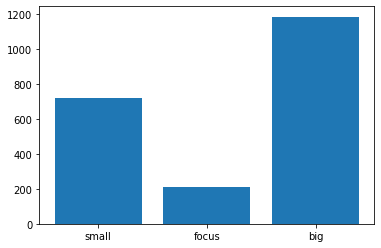

In [9]:
plt.bar(["small", "focus", "big"], counter.values());

In [10]:
# define model
model = DecisionTreeClassifier(min_samples_leaf=25)

We will use repeated cross-validation to evaluate the model, with three repeats of 10-fold cross-validation. The mode performance will be reported using the mean ROC area under curve (ROC AUC) averaged over repeats and all folds.

In [11]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.3f' % np.mean(scores))
print('Accuracy: %.3f' % np.mean(scores))

Accuracy: 0.765


Tying this together, the complete example of defining and evaluating a standard decision tree model on the imbalanced classification problem is listed below.

Decision trees are an effective model for binary classification tasks, although by default, they are not effective at imbalanced classification.

## Imbalanced dataset

The decision tree algorithm is also known as Classification and Regression Trees (CART) and involves growing a tree to classify examples from the training dataset.

The tree can be thought to divide the training dataset, where examples progress down the decision points of the tree to arrive in the leaves of the tree and are assigned a class label.

The tree is constructed by splitting the training dataset using values for variables in the dataset. At each point, the split in the data that results in the purest (least mixed) groups of examples is chosen in a greedy manner.

Here, purity means a clean separation of examples into groups where a group of examples of all 0 or all 1 class is the purest, and a 50-50 mixture of both classes is the least pure. Purity is most commonly calculated using Gini impurity, although it can also be calculated using entropy.

The calculation of a purity measure involves calculating the probability of an example of a given class being misclassified by a split. Calculating these probabilities involves summing the number of examples in each class within each group.

The splitting criterion can be updated to not only take the purity of the split into account, but also be weighted by the importance of each class.

The scikit-learn Python machine learning library provides an implementation of the decision tree algorithm that supports class weighting.

The DecisionTreeClassifier class provides the class_weight argument that can be specified as a model hyperparameter. The class_weight is a dictionary that defines each class label (e.g. 0 and 1) and the weighting to apply in the calculation of group purity for splits in the decision tree when fitting the model.

In [12]:
# define model
weights={0:1.5, 1:1.0, 2:6.0}
model = DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=5, class_weight=weights)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# summarize performance
#print('Mean ROC AUC: %.3f' % np.mean(scores))
print('Accuracy: %.3f' % np.mean(scores))

model.fit(X, y)

Accuracy: 0.720


DecisionTreeClassifier(class_weight={0: 1.5, 1: 1.0, 2: 6.0}, max_depth=4,
                       max_features=5)

### Feature importance

Feature: 0, Score: 0.28914
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00498
Feature: 3, Score: 0.07635
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00908
Feature: 6, Score: 0.62045
Feature: 7, Score: 0.00000


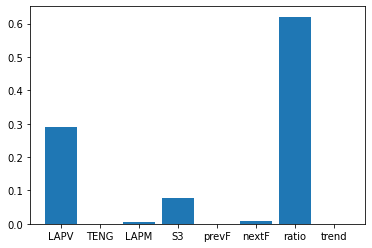

In [13]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in feature_cols], importance)
plt.show()

### Tunning hyperparameters

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [30]:
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,5,6,8,10]
max_features = [2,4,5,6,8,10]

In [31]:
std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = tree.DecisionTreeClassifier()

In [32]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('dec_tree', dec_tree)])

In [34]:
parameters = dict(pca__n_components=n_components,
                  dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth)

In [35]:
model = GridSearchCV(pipe, parameters)
model.fit(x_train, y_train)

#model = DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=5)
#model.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': [2, 4, 5, 6, 8, 10],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8]})

In [38]:
print('Best Criterion:', model.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', model.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', model.best_estimator_.get_params()['pca__n_components'])

Best Criterion: gini
Best max_depth: 4
Best Number Of Components: 8


In [43]:
model.best_estimator_.get_params()

{'memory': None,
 'steps': [('std_slc', StandardScaler()),
  ('pca', PCA(n_components=8)),
  ('dec_tree', DecisionTreeClassifier(max_depth=4))],
 'verbose': False,
 'std_slc': StandardScaler(),
 'pca': PCA(n_components=8),
 'dec_tree': DecisionTreeClassifier(max_depth=4),
 'std_slc__copy': True,
 'std_slc__with_mean': True,
 'std_slc__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 8,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'dec_tree__ccp_alpha': 0.0,
 'dec_tree__class_weight': None,
 'dec_tree__criterion': 'gini',
 'dec_tree__max_depth': 4,
 'dec_tree__max_features': None,
 'dec_tree__max_leaf_nodes': None,
 'dec_tree__min_impurity_decrease': 0.0,
 'dec_tree__min_impurity_split': None,
 'dec_tree__min_samples_leaf': 1,
 'dec_tree__min_samples_split': 2,
 'dec_tree__min_weight_fraction_leaf': 0.0,
 'dec_tree__presort': 'deprecated',
 'dec_tree__random_state': None,
 'dec_tree__splitter'

In [44]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f' % np.mean(scores))

Accuracy: 0.750


In [19]:
scores = cross_val_score(model, x_train, y_train, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('F1 weighted: %.3f' % np.mean(scores))

F1 weighted: 0.743


In [21]:
scores = cross_val_score(model, x_train, y_train, scoring='recall_weighted', cv=cv, n_jobs=-1)
print('Recall weighted: %.3f' % np.mean(scores))

Recall weighted: 0.744


In [22]:
scores = cross_val_score(model, x_train, y_train, scoring='precision_weighted', cv=cv, n_jobs=-1)
print('Precision weighted: %.3f' % np.mean(scores))

Precision weighted: 0.744


In [17]:
y_pred = model.predict(x_test)

In [18]:
from sklearn.metrics import confusion_matrix

# confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[128  33  12]
 [ 37 265   5]
 [ 14   6  30]]


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [20]:
def encodeLabels(y_train, y_test):

    labelencoder = LabelEncoder().fit(y_train)
    y_train = labelencoder.transform(y_train)

    labelencoder = LabelEncoder().fit(y_test)
    y_test = labelencoder.transform(y_test)
    
    print(labelencoder.classes_)
    
    return y_train, y_test, labelencoder

In [21]:
y_train, y_test, labelencoder = encodeLabels(y_train, y_test)

[0 1 2]


F1 SCORE:  0.7982021934576905
Precision SCORE:  0.7985651366088162
Recall SCORE:  0.7981132075471699
Accuracy: 0.751


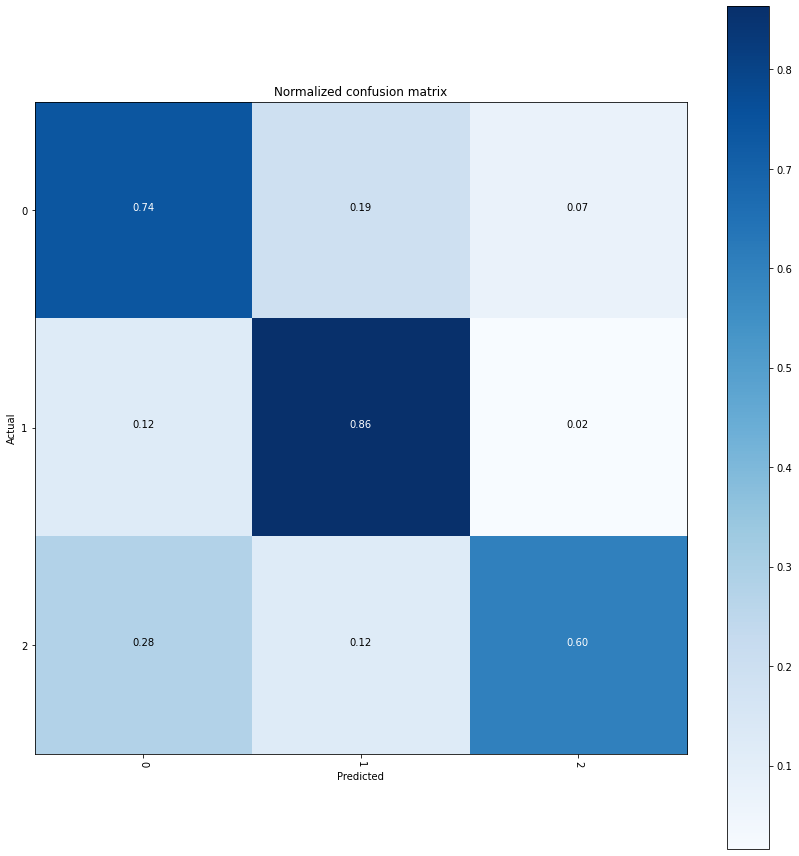

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import itertools


print('F1 SCORE: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision SCORE: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall SCORE: ', recall_score(y_test, y_pred, average='weighted'))
print('Accuracy: %.3f' % np.mean(scores))

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_, normalize=True, title='Normalized confusion matrix')

plt.yticks(list(np.arange(3)),list(labelencoder.classes_), size=10)
plt.xticks(list(np.arange(3)),list(labelencoder.classes_), size=10, rotation=270)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

In [25]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

ValueError: multiclass format is not supported

#### Tree Depth

In [23]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

ValueError: multiclass format is not supported

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data

#### Min samples splits

In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

We can clearly see that when we consider 100% of the samples at each node, the model cannot learn enough about the data. This is an underfitting case.

#### min sample leafs

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Same conclusion as to previous parameter. Increasing this value may cause underfitting.

#### Max features

In [ ]:
max_features = list(range(1,X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

This is also an overfitting case. It’s unexpected to get overfitting for all values of max_features. However, according to sklearn documentation for decision tree, the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

In [ ]:
model.classes_ # 0: small, 1: big, 2:focus

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names=['small', 'big', 'focus'])
                #special_characters=True,feature_names = feature_cols,class_names=['1','2','3','4','5','6','7','8','9','10'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('album.png')

In [ ]:
Image(graph.create_png())

In [ ]:

from sklearn.externals.six import StringIO
from sklearn import tree
from IPython.display import Image
from subprocess import call

#Exportar a formato dot
file_name='tree.out'
tree.export_graphviz(model, out_file=file_name, feature_names = feature_cols,class_names=['small', 'big', 'focus'])
# Ejecuta un comando en la terminal. Esta línea es solo valida para linux y dot debe estar instalado
call(['dot', '-Tpng', file_name, '-o' 'tree.png'])
Image(filename='tree.png')